In [1]:
# при установке pytorch geometric бывают трудности с пакетом torch-sparse нужно выбирать правильную версию cuda и pytorch
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-geometric
!pip install umap-learn

Looking in links: https://data.pyg.org/whl/torch-1.9.0+cu111.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3588727 sha256=4331b08d14c090015a462d903b0fc0da6d42831dd372c8b8fd787f39d158663f
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.9.0+cu111.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=2731960 sha256=8f3fb23fc337f4bfe3d607f0360c9e8cfa82985f410c307b6349f99803abdaa9
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built t

In [2]:
from torch_geometric.nn import DeepGraphInfomax as DGI
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
from torch_geometric.datasets import TUDataset
import torch.nn as nn
import numpy as np

In [3]:
# классический датасет CORA
dataset = 'Cora'
path = './data'
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]

Processing...
Done!


In [5]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

Так как граф задан целиком на входе, то можно использовать трансдуктивный подход к обучению DGI, если в графе появляются новые вершины и связи в течение времени - то нужен индуктивный вариант, там немного другая архитектура.
Нам нужен какой-нибудь энкодер, чтобы получить т.н. patch representations (которые потом будут использоваться для получения graph-level репрезентаций).
Мы берем все параметры, такие как Velickovic использовал в [статье](https://arxiv.org/pdf/1809.10341.pdf).
corruption function нужна, чтобы делать семплинг негативных примеров (делаем row-wise shuffling исходной матрицы), по сути corrupted graph состоит из тех же вершин, что оригинальный, но в нем вершины находятся в других местах. corruption function может быть какой-нибудь другой, например, можно порезать ребра в исходном графе.

Используйте различные архитектуры энкодера, чтобы получить лучший результат по метрике, опишите ваши подходы и оставьте вывод. Попробуйте **минимум 3** разных варианта. Каждый подход оценивается в 3 балла + 1 балл за визуализацию и интерпретацию.

Вы можете использовать предложенную визуализацию, либо реализовать другим способом и получить дополнительные 2 балла к заданию.
[Форма](https://forms.gle/q6NMQs3QLJQ48dut9) для отправки до 19.03 23:59 msk

In [39]:
def corruption(x, edge_index):
    return x[torch.randperm(x.size(0), device=x.device)], edge_index

In [40]:
def train():
    model.train()
    optimizer.zero_grad()
    pos_z, neg_z, summary = model(data.x, data.edge_index)
    loss = model.loss(pos_z, neg_z, summary)
    loss.backward()
    optimizer.step()
    return loss.item()


def test():
    model.eval()
    z, _, _ = model(data.x, data.edge_index)
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask], max_iter=150)
    return acc, z

1. GCN. Эмбеддинг ноды после применения слоя GCNConv рассчитывается по формуле.
$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$
$\mathbf{W}$ - обучаемая матрица, $c_{\omega,v}$ - коэффициенты нормализации, индивидуальные для каждого соседа

In [48]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCNEnc(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(44)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCNEnc(hidden_channels=16)
print(model)

GCNEnc(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
)


2. SAGEConv. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.SAGEConv.html

In [96]:
from torch_geometric.nn import SAGEConv

class SAGEEnc(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(dataset.num_features, hidden_channels)
        # self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        # с двумя слоями качество намного хуже

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        # x = F.relu(self.conv2(x, edge_index))
        return x

model = SAGEEnc(hidden_channels=16)
print(model)

SAGEEnc(
  (conv1): SAGEConv(1433, 16, aggr=mean)
)


3. GAT. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html#torch_geometric.nn.conv.GATConv

In [114]:
from torch_geometric.nn import GATConv

class GATEncoder(nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=1, concat = False)
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=1, concat = False)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        return x

model = GATEncoder(hidden_channels=16)
print(model)

GATEncoder(
  (conv1): GATConv(1433, 16, heads=1)
  (conv2): GATConv(16, 16, heads=1)
)


DGI

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DGI(
    hidden_channels=512, encoder=GCNEnc(512),
    summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)),
    corruption=corruption).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [52]:
for epoch in range(1, 300): #желательно поставить побольше, например 300
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
acc, out = test()
print(f'Accuracy: {acc:.4f}')

Epoch: 001, Loss: 1.3861
Epoch: 002, Loss: 1.4071
Epoch: 003, Loss: 1.3778
Epoch: 004, Loss: 1.3853
Epoch: 005, Loss: 1.3735
Epoch: 006, Loss: 1.3665
Epoch: 007, Loss: 1.3598
Epoch: 008, Loss: 1.3416
Epoch: 009, Loss: 1.3244
Epoch: 010, Loss: 1.3047
Epoch: 011, Loss: 1.2660
Epoch: 012, Loss: 1.2375
Epoch: 013, Loss: 1.2004
Epoch: 014, Loss: 1.1443
Epoch: 015, Loss: 1.0985
Epoch: 016, Loss: 1.0592
Epoch: 017, Loss: 1.0417
Epoch: 018, Loss: 0.9472
Epoch: 019, Loss: 0.9221
Epoch: 020, Loss: 0.8803
Epoch: 021, Loss: 0.7727
Epoch: 022, Loss: 0.7761
Epoch: 023, Loss: 0.6992
Epoch: 024, Loss: 0.6463
Epoch: 025, Loss: 0.6467
Epoch: 026, Loss: 0.5507
Epoch: 027, Loss: 0.5581
Epoch: 028, Loss: 0.4928
Epoch: 029, Loss: 0.4743
Epoch: 030, Loss: 0.4812
Epoch: 031, Loss: 0.4051
Epoch: 032, Loss: 0.3888
Epoch: 033, Loss: 0.3849
Epoch: 034, Loss: 0.3556
Epoch: 035, Loss: 0.3244
Epoch: 036, Loss: 0.2955
Epoch: 037, Loss: 0.2939
Epoch: 038, Loss: 0.3179
Epoch: 039, Loss: 0.2399
Epoch: 040, Loss: 0.2761


In [54]:
palette = {}

for n, y in enumerate(set(data.y.cpu().numpy())):
    palette[y] = f'C{n}'

In [55]:
import umap.umap_ as umap
import seaborn as sns

In [56]:
embd = umap.UMAP().fit_transform(out.detach().cpu().numpy())

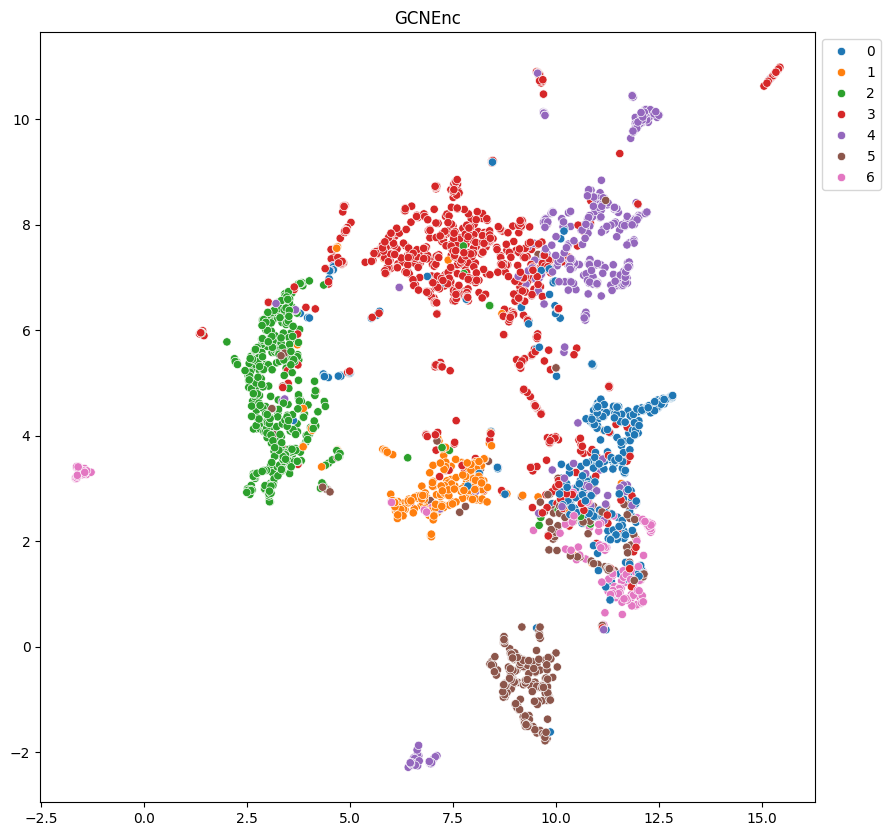

In [63]:
# UMAP plot после DGI
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.title('GCNEnc')
plt.savefig("GCEEnc_umap_embd_dgi.png", dpi=120)

In [61]:
embd_x = umap.UMAP().fit_transform(data.x.cpu().numpy())

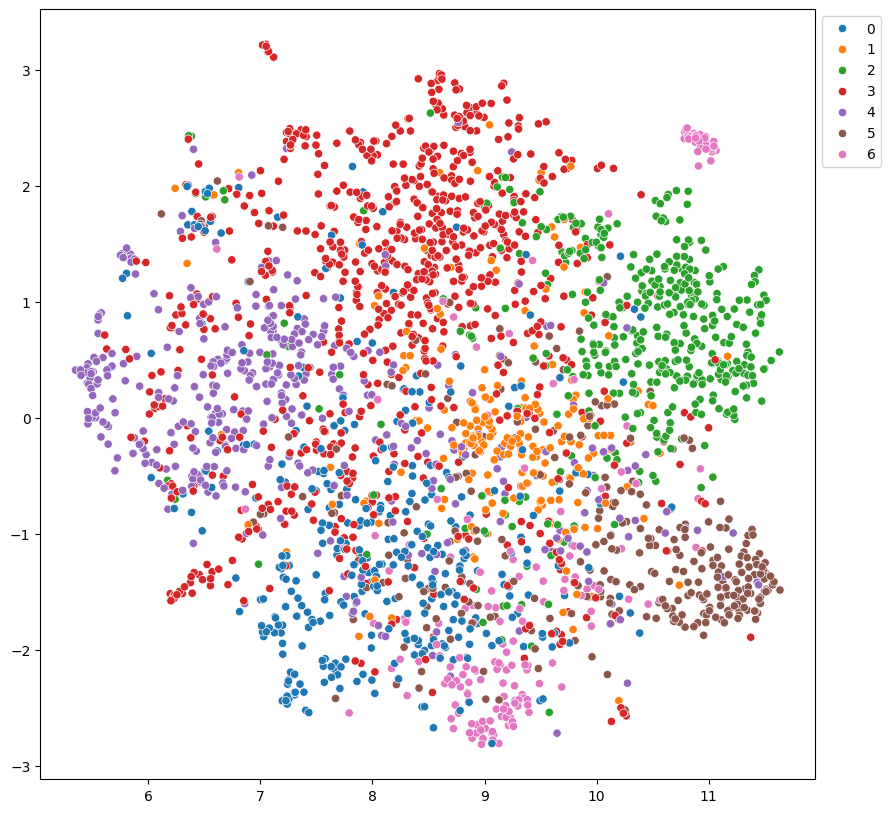

In [62]:
# исходник
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd_x.T[0], y=embd_x.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig("umap_embd.png", dpi=120)

In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DGI(
    hidden_channels=512, encoder=SAGEEnc(512),
    summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)),
    corruption=corruption).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 300): #желательно поставить побольше, например 300
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
acc, out = test()
print(f'Accuracy: {acc:.4f}')

Epoch: 001, Loss: 1.3873
Epoch: 002, Loss: 1.5833
Epoch: 003, Loss: 1.3917
Epoch: 004, Loss: 1.4117
Epoch: 005, Loss: 1.4520
Epoch: 006, Loss: 1.4285
Epoch: 007, Loss: 1.3935
Epoch: 008, Loss: 1.3738
Epoch: 009, Loss: 1.3696
Epoch: 010, Loss: 1.3728
Epoch: 011, Loss: 1.3726
Epoch: 012, Loss: 1.3706
Epoch: 013, Loss: 1.3607
Epoch: 014, Loss: 1.3488
Epoch: 015, Loss: 1.3333
Epoch: 016, Loss: 1.3194
Epoch: 017, Loss: 1.3069
Epoch: 018, Loss: 1.2936
Epoch: 019, Loss: 1.2753
Epoch: 020, Loss: 1.2466
Epoch: 021, Loss: 1.2208
Epoch: 022, Loss: 1.2053
Epoch: 023, Loss: 1.1750
Epoch: 024, Loss: 1.1504
Epoch: 025, Loss: 1.1234
Epoch: 026, Loss: 1.0850
Epoch: 027, Loss: 1.0448
Epoch: 028, Loss: 1.0009
Epoch: 029, Loss: 0.9720
Epoch: 030, Loss: 0.9400
Epoch: 031, Loss: 0.8769
Epoch: 032, Loss: 0.8529
Epoch: 033, Loss: 0.8312
Epoch: 034, Loss: 0.7835
Epoch: 035, Loss: 0.7342
Epoch: 036, Loss: 0.7332
Epoch: 037, Loss: 0.6861
Epoch: 038, Loss: 0.6399
Epoch: 039, Loss: 0.6126
Epoch: 040, Loss: 0.5854


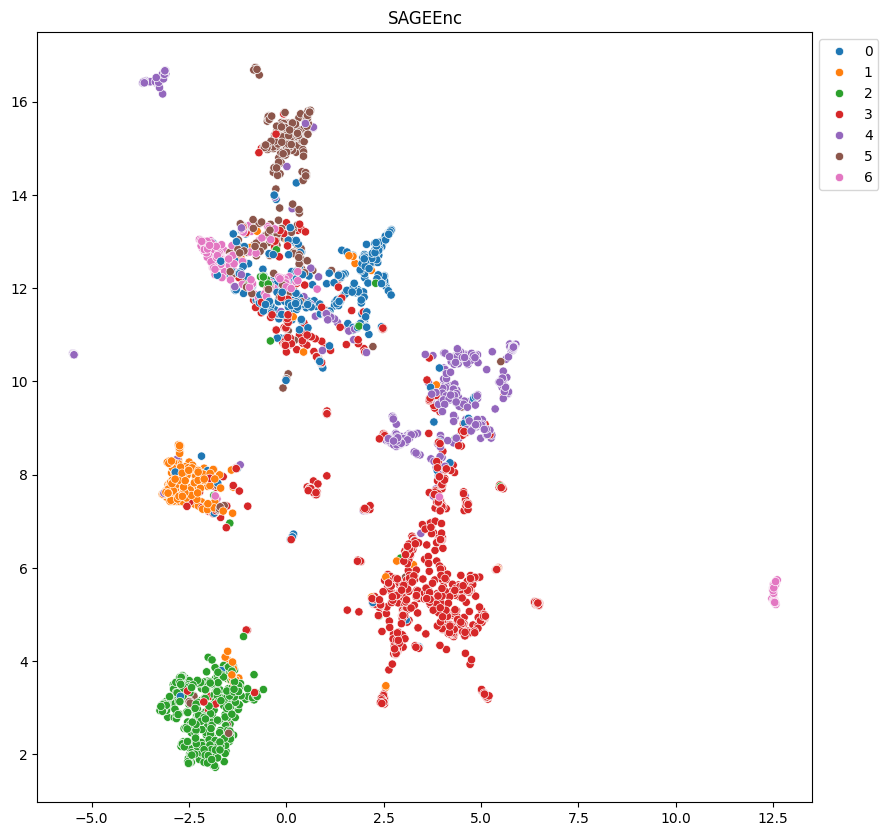

In [95]:
palette = {}
for n, y in enumerate(set(data.y.cpu().numpy())):
    palette[y] = f'C{n}'

embd = umap.UMAP().fit_transform(out.detach().cpu().numpy())

# UMAP plot после DGI
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.title('SAGEEnc')
plt.savefig("SAGEEnc_umap_embd_dgi.png", dpi=120)

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DGI(
    hidden_channels=512, encoder=GATEncoder(512),
    summary=lambda z, *args, **kwargs: torch.sigmoid(z.mean(dim=0)),
    corruption=corruption).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 300): #желательно поставить побольше, например 300
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
acc, out = test()
print(f'Accuracy: {acc:.4f}')

Epoch: 001, Loss: 1.3869
Epoch: 002, Loss: 1.3978
Epoch: 003, Loss: 1.4077
Epoch: 004, Loss: 1.3786
Epoch: 005, Loss: 1.3794
Epoch: 006, Loss: 1.3778
Epoch: 007, Loss: 1.3655
Epoch: 008, Loss: 1.3653
Epoch: 009, Loss: 1.3410
Epoch: 010, Loss: 1.3483
Epoch: 011, Loss: 1.3104
Epoch: 012, Loss: 1.3010
Epoch: 013, Loss: 1.2679
Epoch: 014, Loss: 1.2446
Epoch: 015, Loss: 1.2633
Epoch: 016, Loss: 1.2562
Epoch: 017, Loss: 1.2078
Epoch: 018, Loss: 1.2219
Epoch: 019, Loss: 1.2168
Epoch: 020, Loss: 1.1693
Epoch: 021, Loss: 1.1798
Epoch: 022, Loss: 1.1841
Epoch: 023, Loss: 1.1424
Epoch: 024, Loss: 1.1423
Epoch: 025, Loss: 1.1329
Epoch: 026, Loss: 1.1391
Epoch: 027, Loss: 1.1056
Epoch: 028, Loss: 1.0951
Epoch: 029, Loss: 1.0761
Epoch: 030, Loss: 1.0822
Epoch: 031, Loss: 1.1127
Epoch: 032, Loss: 1.0503
Epoch: 033, Loss: 1.0682
Epoch: 034, Loss: 1.0622
Epoch: 035, Loss: 1.0350
Epoch: 036, Loss: 1.0040
Epoch: 037, Loss: 1.0236
Epoch: 038, Loss: 1.0207
Epoch: 039, Loss: 1.0438
Epoch: 040, Loss: 1.0277


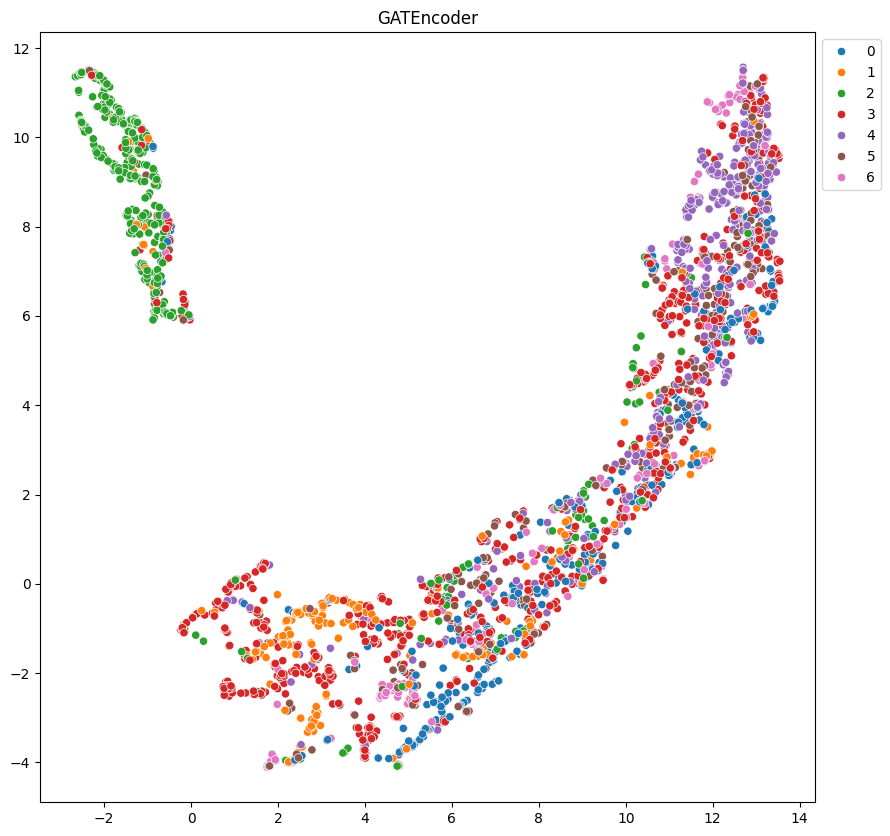

In [113]:
palette = {}
for n, y in enumerate(set(data.y.cpu().numpy())):
    palette[y] = f'C{n}'

embd = umap.UMAP().fit_transform(out.detach().cpu().numpy())

# UMAP plot после DGI
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.title('GATEncoder')
plt.savefig("GATEncoder_umap_embd_dgi.png", dpi=120)

Лучшее качество у модели SAGE с одним слоем: accuracy = 0.75 (с двумя в 2 раза хуже, видимо, переобучение).\
На втором месте GCN c двумя слоями: accuracy = 0.68\
На третьем месте GAT: accuracy = 0.36. При добавлении голов сильное переобучение.